#Realização de execução teste utilizando FASTAI



#1. Importação do dataset de teste e ajustes de data.   



[1] Importação das bibliotecas relacionadas ao FastAI

In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

[2] Download de um dataset teste chamdo CAMVID; Dataset contendo imagens de ruas.

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels')]

[3] Especificação do caminho das imagens e labels.

In [3]:
path_labels = path/'labels'
path_images = path/'images'

[4] Caso teste abrindo uma das imagens contidas no dataset.

In [7]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f04140.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06900.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08095.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01800.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05040.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05880.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07987.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02160.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008730.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04350.png')]

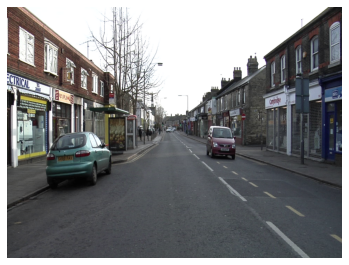

In [8]:
image_file = filenames[0]
image = open_image(image_file)
image.show(figsize=(6,6))

[5] Associando labels de acordo com cada imagem presente no caminho 'path_labels'

In [9]:
get_y_fn = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

[6] Mostrando uma máscara.

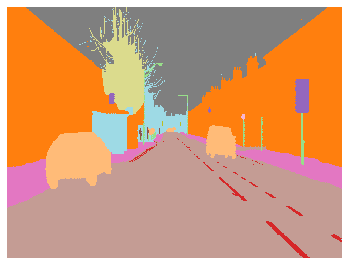

In [10]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

[7] No dataset há um arquivo nomeado 'codes.txt' que apresenta como conteúdo um conjunto de palavras que ajudam na hora da classificação.

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
len(codes), codes

(32,
 array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
        'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
        'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17'))

[8] Convertendo a máscara para um numpy array:

In [12]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))



#2. Criação dos lotes e suas exibições



[1] Criando uma lista de segmentação. Neste caso, para cada imagem é lido um arquivo de validação e também associado uma label para a mesma.

In [13]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_fname_file('../valid.txt')
              .label_from_func(get_y_fn, classes=codes))

[2] Preparando toda a 'data' passando a lista de segmentação transformada (Evitar overfitting) 

In [16]:
size = source_size//2
bs = 0
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

using bs=8, have 11438MB of GPU RAM free


[3] Exibição de um lote aleatório

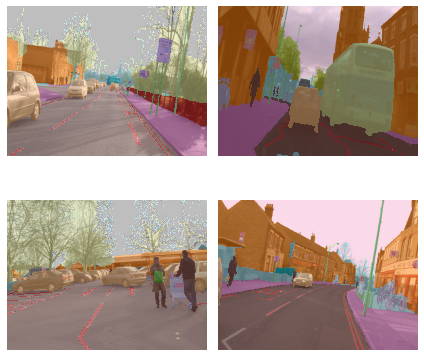

In [17]:
databunch.show_batch(2, figsize=(6, 6))

#3. Modelo (Unet with Resnet)

[1] Preparativos para a Accuracy além do estabelecimento do leaner usando o modelo unet com resnet34.

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid

wd=1e-2

learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                       callback_fns=ShowGraph).to_fp16()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#4 Mostrando resultados indentificando pessoas

epoch,train_loss,valid_loss,acc_camvid,time
0,1.009010,0.710202,0.813355,03:10
1,0.758487,0.540121,0.852670,03:10
2,0.684354,0.572261,0.844594,03:10
3,0.630389,0.484666,0.863808,03:09
4,0.583263,0.458553,0.878224,03:10
5,0.566040,0.609961,0.855001,03:10
6,0.607068,0.545369,0.848171,03:10
7,0.601401,0.520332,0.865419,03:09
8,0.537284,0.433145,0.875149,03:09
9,0.449652,0.334528,0.899758,03:09


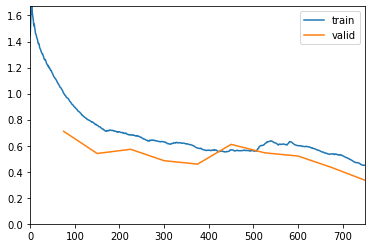

In [21]:
lr=3e-3
learner.fit_one_cycle(10, slice(lr), pct_start=0.9)

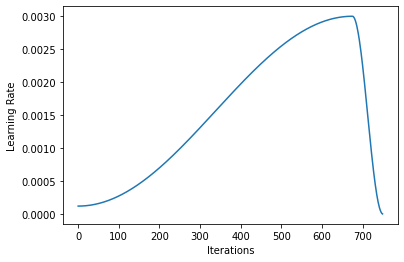

In [22]:
learner.recorder.plot_lr()

In [23]:
learner.save('unet-resnet34-1')

In [24]:
learner.load('unet-resnet34-1');

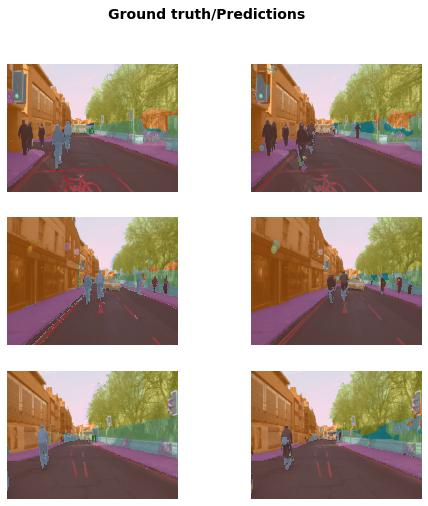

In [25]:
learner.show_results(rows=3, figsize=(8, 8))